# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

# Keras
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import pathlib

# Dataset

In [2]:
data_dir = pathlib.Path('App/res/images_AI/')

image_count = len(list(data_dir.glob('*/*.png')))
print(f"The number of images is :{image_count}")


The number of images is :80


# Creating a dataset for Keras

In [3]:
# Parametres
batch_size = 32
img_height = 160
img_width = 160

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 80 files belonging to 20 classes.
Using 64 files for training.
Found 80 files belonging to 20 classes.
Using 16 files for validation.


## Checking classes

In [4]:
class_names = train_ds.class_names
print(class_names)

['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '3', '4', '5', '6', '7', '8', '9']


# Visualize the data

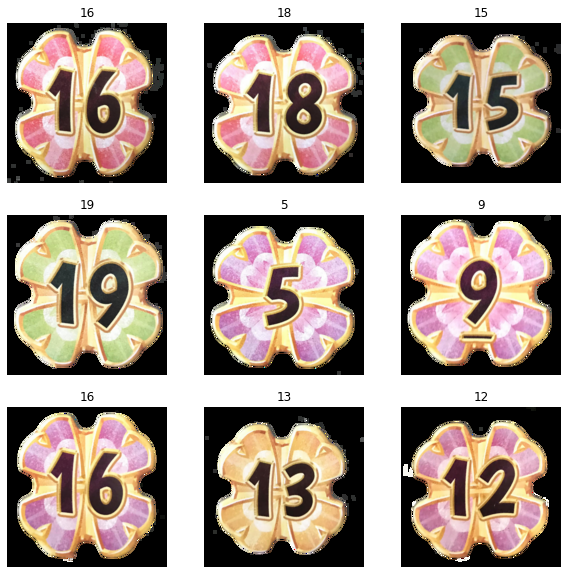

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Manual retrieving of images by batch

In [6]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 160, 160, 3)
(32,)


## Performance

In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Data normalization

In [8]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [9]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


# Model creation

In [10]:
num_classes = 20

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile the model

In [11]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 160, 160, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 160, 160, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 80, 80, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 80, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 40, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 64)        0

# Model training

In [13]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
2/2 [==============================] - 1s 431ms/step - loss: 3.1621 - accuracy: 0.0312 - val_loss: 3.1129 - val_accuracy: 0.0000e+00
Epoch 2/10
2/2 [==============================] - 1s 296ms/step - loss: 2.9158 - accuracy: 0.1094 - val_loss: 3.0821 - val_accuracy: 0.0000e+00
Epoch 3/10
2/2 [==============================] - 1s 287ms/step - loss: 2.8340 - accuracy: 0.1094 - val_loss: 3.1356 - val_accuracy: 0.0625
Epoch 4/10
2/2 [==============================] - 1s 269ms/step - loss: 2.7034 - accuracy: 0.4375 - val_loss: 3.1818 - val_accuracy: 0.0000e+00
Epoch 5/10
2/2 [==============================] - 1s 267ms/step - loss: 2.5127 - accuracy: 0.4844 - val_loss: 3.1896 - val_accuracy: 0.0625
Epoch 6/10
2/2 [==============================] - 1s 275ms/step - loss: 2.2664 - accuracy: 0.5625 - val_loss: 3.0729 - val_accuracy: 0.1250
Epoch 7/10
2/2 [==============================] - 1s 264ms/step - loss: 1.9382 - accuracy: 0.6875 - val_loss: 3.0623 - val_accuracy: 0.1250
Epoch 8/

# Visualize training results

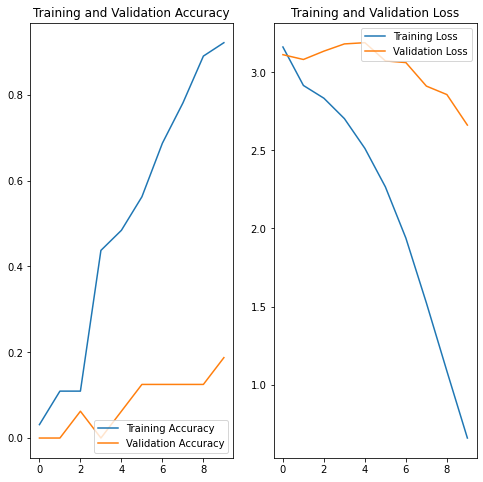

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Dropout

In [15]:
num_classes = 20

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

# Recompiling the model

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 160, 160, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 160, 160, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 80, 80, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 80, 80, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 40, 40, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 20, 20, 64)       

In [18]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
2/2 [==============================] - 1s 324ms/step - loss: 3.3089 - accuracy: 0.0625 - val_loss: 3.1442 - val_accuracy: 0.0625
Epoch 2/15
2/2 [==============================] - 1s 286ms/step - loss: 2.8928 - accuracy: 0.0781 - val_loss: 3.1483 - val_accuracy: 0.0000e+00
Epoch 3/15
2/2 [==============================] - 1s 268ms/step - loss: 2.8271 - accuracy: 0.1250 - val_loss: 3.1600 - val_accuracy: 0.0000e+00
Epoch 4/15
2/2 [==============================] - 1s 266ms/step - loss: 2.7189 - accuracy: 0.3125 - val_loss: 3.1801 - val_accuracy: 0.0000e+00
Epoch 5/15
2/2 [==============================] - 1s 276ms/step - loss: 2.5569 - accuracy: 0.4688 - val_loss: 3.1990 - val_accuracy: 0.0625
Epoch 6/15
2/2 [==============================] - 1s 274ms/step - loss: 2.2954 - accuracy: 0.4531 - val_loss: 3.2531 - val_accuracy: 0.0000e+00
Epoch 7/15
2/2 [==============================] - 1s 291ms/step - loss: 1.9580 - accuracy: 0.5469 - val_loss: 3.2916 - val_accuracy: 0.0625
Epoc

# Visualize the new results

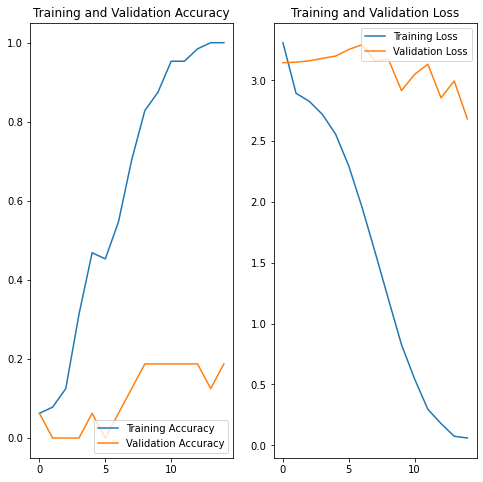

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Testing the model

This image most likely belongs to 10 with a 99.09 percent confidence.


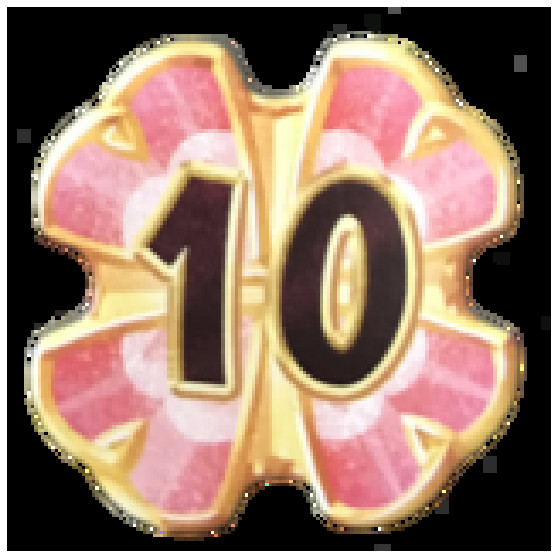

In [23]:
test_path = "App/res/images_AI/10/10red.png"

img = keras.preprocessing.image.load_img(
    test_path, target_size=(img_height, img_width)
)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis("off")

img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


# OLD THINGS TO TEST MAYBE

In [21]:
IMG_SIZE = 160

IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [22]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________